# Titanic for Beginners
![](https://i.imgur.com/rRFchA8.png)

## 目次
0. ライブラリ・データ読み込み
1. データの概観・分析・前処理
2. 機械学習モデルの構築・学習
3. 予測の出力・提出

　このノートブックでは目次のように、データに最低限の整形を施して、機械学習モデルを学習し、予測を出力して提出するまでの流れを確認します。より本格的な取り組み方については、**professional.ipynb**を参照してください。

## 0. ライブラリ・データ読み込み  
　まず初めに使用するライブラリを読み込みます。

In [ ]:
# このセルを実行したあとどうすればいいかがわからない方は、別途配布している、Notionの「Google Colabの使用方法」をご覧ください。

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns # よりきれいなグラフを描画するためのライブラリ

from sklearn.model_selection import train_test_split # データを学習用とテスト用に分割するための関数
from sklearn.linear_model import LogisticRegression # ロジスティック回帰を行うためのクラス

import warnings # 実行に関係ない警告を非表示にする
warnings.filterwarnings('ignore')

　次にpandasのread_csv関数を用いて、分析する訓練データ**train.csv**とテストデータ**test.csv**を読み込みます。  
　変数名に与えた**df**は、**DataFrame**を意味しています（変数名は何でも構いません）。テストデータは素直にdf_testと命名したのに対して訓練データはdfとだけ命名したのは、後に説明するホールドアウト法やクロスバリデーションにおいて、さらにdfを擬似的な訓練データdf_trainと擬似的なテストデータdf_validに分割することを見越してのものです。\
※ファイルの読み込み方法は自身の作業場所によって変わります。このnotebookをコピーして用いる場合はそのまま実行することができますが、自分の環境に合わせて適切な形に修正する必要が生じる場合もあります。

In [9]:
# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、Notionの「Google Colabの使用方法」をご覧ください。
path = "../data/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

## 1. データの概観・前処理
### 1.1 データの概観
　データを見ていく上で、まず初めにデータのサイズを確認してみましょう。

In [ ]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1])) # データ数と変数の数を表示
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は891、変数は12種類です。
テスト1データのデータ数は418、変数は11種類です


　訓練データの初めの10データを見てみましょう。

In [ ]:
df.head(10) # 先頭10行を表示

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,1,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,1,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


　変数名の一覧を見てみましょう。

In [41]:
df.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket'],
      dtype='object')

　これらの変数名を、README.ipynbに示された変数の説明と対応付けておきましょう。  

変数 |定義 |備考  
---|---|---
Perished |死亡したかどうか |0 = No, 1 = Yes
Pclass |チケットのクラス |1 = 1st, 2 = 2nd, 3 = 3rd
Name |名前 |
Sex |性別 |
Age	|年齢 |
SibSp |乗船していた兄弟姉妹・配偶者の数	|
Parch |乗船していた親・子供の数	|
Ticket |チケット番号	|
Fare |チケット料金	|
Cabin |キャビン番号	|
embarked |乗船した港	|C = Cherbourg, Q = Queenstown, S = Southampton



### 1.2 データの分析
　次に**EDA**と呼ばれる作業を行います。EDAとは、**Exploratory Data Analysis**の略で、日本語では**探索的データ分析**と訳されます。EDAでは、データを様々な角度から可視化したり、統計量を見ることで、データの特徴や構造を掴もうと試みます。この工程で得られた知見は機械学習モデルを選ぶ上でも、後に述べる特徴量エンジニアリングにおいても有用です。EDAで得た知見が役立つ理由の一つは、機械学習モデルによって仮定しているデータの特徴が異なることです。EDAによりデータに線型性・独立性・連続性などの特徴が観察できたり、後述の特徴量エンジニアリングでデータを加工することにより顕著な特徴を有した新しいデータを得ることができれば、それに適した機械学習モデルを用いることができます。  
　以下に行うEDAは、"EDA To Prediction (DieTanic)"というAshwini Swain氏によるKaggle Notebookを参考にしたものです。
  
EDA To Prediction (DieTanic)：https://www.kaggle.com/ash316/eda-to-prediction-dietanic

　まずは欠損値を確認しておきましょう。機械学習を用いたデータ分析に取り組む上で欠損値の確認は必須となっています。なぜならほとんどの機械学習モデルの実装は欠損値を含むデータに対して学習や予測ができず、エラーとなってしまうからです。

In [ ]:
df.isnull().sum() # 欠損値の数をカウント

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

　**Age**、**Fare**, **Cabin**、**Embarked**の値の一部が欠損していることがわかりました。これらには後で対処することとします。  

　次に生存者の割合をみてみましょう。

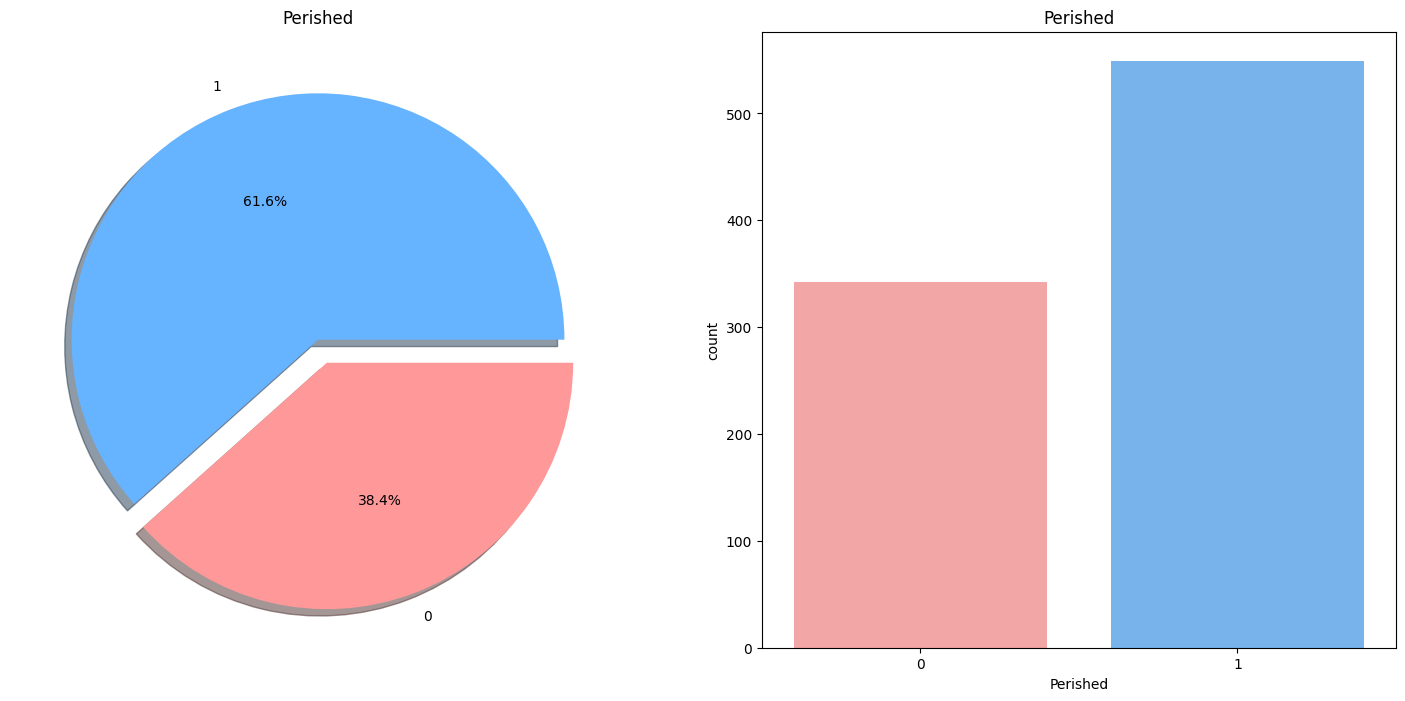

In [31]:
# 1行2列のグラフを描画する f: figure画像, ax: axis軸
f,ax=plt.subplots(1,2,figsize=(18,8)) 
colors = ['#ff9999', '#66b3ff']  # 任意の色を指定するリスト


# 円グラフ
# value_counts(): それぞれの要素の個数をカウント
# explode: グラフから切り離す要素, 2つのセグメントのうち、2番目のセグメントを少し外側にずらして強調します。
# autopct: グラフ上に割合を表示する
# ax[0]: 1行2列のグラフの1番目
# shadow: グラフに影をつける
df['Perished'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, colors=[colors[1], colors[0]]) 
ax[0].set_title('Perished')
ax[0].set_ylabel('')

# 棒グラフ
# X軸に「Perished」の値を使用し、Y軸に「Perished」の値の個数を使用
sns.countplot(x='Perished',data=df,ax=ax[1], palette=colors)
ax[1].set_title('Perished')
plt.show()

　生存率は38.4%であることがわかりました。分析対象となるデータには様々ありますが、一つの分類に**均衡データ**/**不均衡データ**というものがあります。不均衡データとは、主に予測対象のラベルの分布が著しく偏ったデータのことであり、病気の陽性/陰性などがその代表例です。不均衡データを分析する際には、データの前処理やモデルの構築、評価指標の選び方など様々な点において注意しなければなりません。しかし今回の予測対象であるPerishedは生存:死亡がおよそ4:6と均衡しているので、そうした心配の必要はありません。  

　次にデータの型について見てみましょう。機械学習を用いてデータ分析を行う際には、データの型にも注意が必要です。なぜならほとんどの機械学習モデルの実装はカテゴリカル変数を含むデータに対して学習や予測ができず、エラーとなってしまうからです。  
　データの型には大別して**数値データ**と**カテゴリカルデータ**があります。他にも日付・時間データなどがあったり、連続値データ/離散値データの区別があったりしますが、ここでは扱いません。数値データは文字通り数値が格納されたデータであり、カテゴリカルデータは主に文字列によってその分類が示されたデータです。ただしデータが数値であっても、その値の大小や順序が意味を持たない場合にはカテゴリカルデータとして扱う必要がある点には注意が必要です。  
　この観点では今回のデータは以下のように分類されます。
- 数値データ：Pclass, Age, SibSp, Parch, Fare
- カテゴリカルデータ：Name, Sex, Ticket, Embarked

　これらのカテゴリカルデータは機械学習モデルで扱えるよう、後で適切に処理します。

　ここからは一つ一つの変数について見ていきましょう。ただし、ここではデモンストレーションとして一部しか扱いません。またデータ分析コンペティションでは、必ずしも全てのEDAを自分で一から行う必要はありません。基本的なEDAは多くの場合Kaggle Notebookとして共有されますし、pandas-profilingなどの便利なライブラリを用いれば済んでしまうからです。しかし他の参加者との差別化を図るには、自らEDAで得た知見を活用する必要があります。また実務においてEDAを肩代わりしてくれる人はいません。これらの理由から、やはり自分である程度のEDAをこなせる必要はあるでしょう。

　まずは**Pclass**（チケットのクラス）について見ていきます。

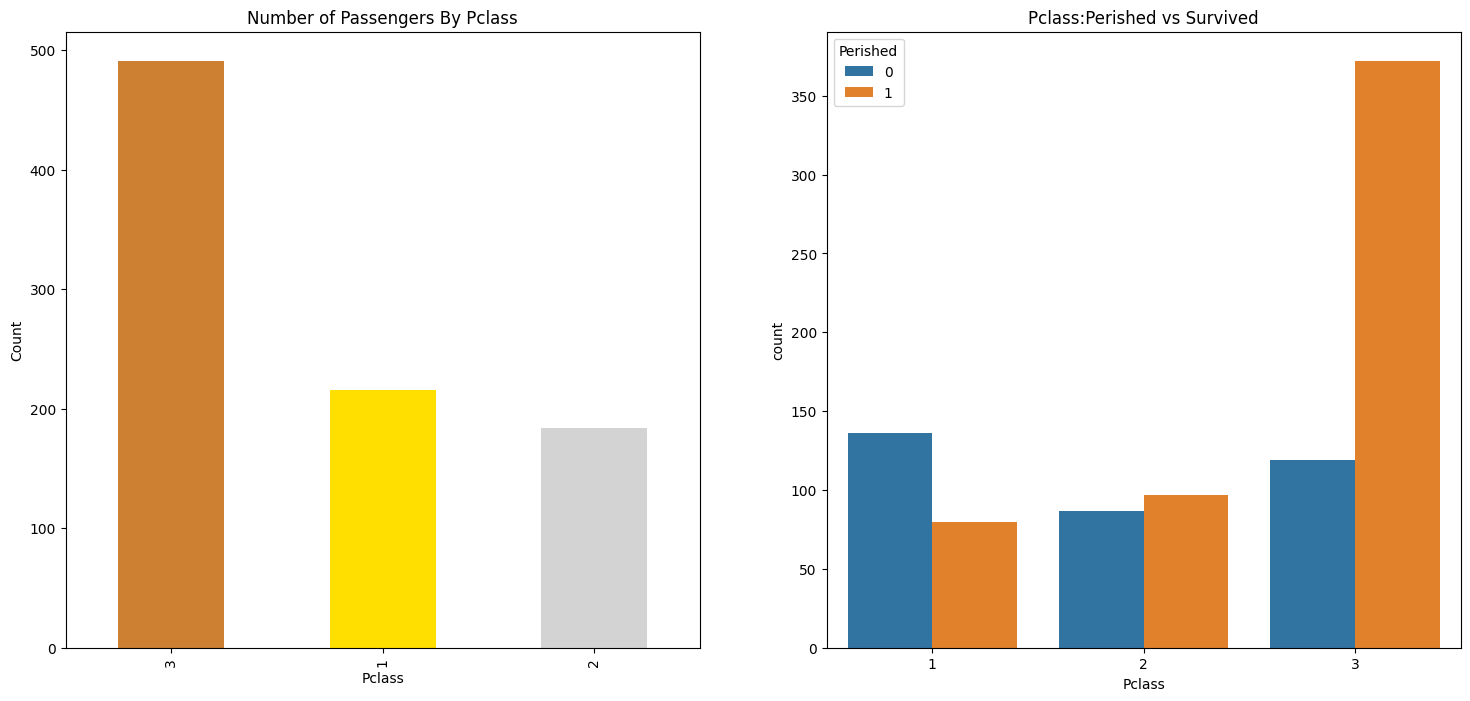

In [33]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')

# PclassごとにPerishedの状態を色分けするカウントプロット
sns.countplot(x='Pclass',hue='Perished',data=df,ax=ax[1])
ax[1].set_title('Pclass:Perished vs Survived')
plt.show()

　Pclassごとに人数および死亡率が著しく異なっていることが見て取れます。特にPclass=3は人数が圧倒的に多く、死亡率が著しく高いことがわかります。一方でPclass=1は死亡率が非常に低くなっています。Pclassはチケットのクラスでしたから、ここに見た事実は、Pclassの値が小さいほどチケットのグレードが高いことを直ちに示唆しています。他にはどのような知見が得られるか考えてみましょう。

　次に**Age**（年齢）について見てみます。

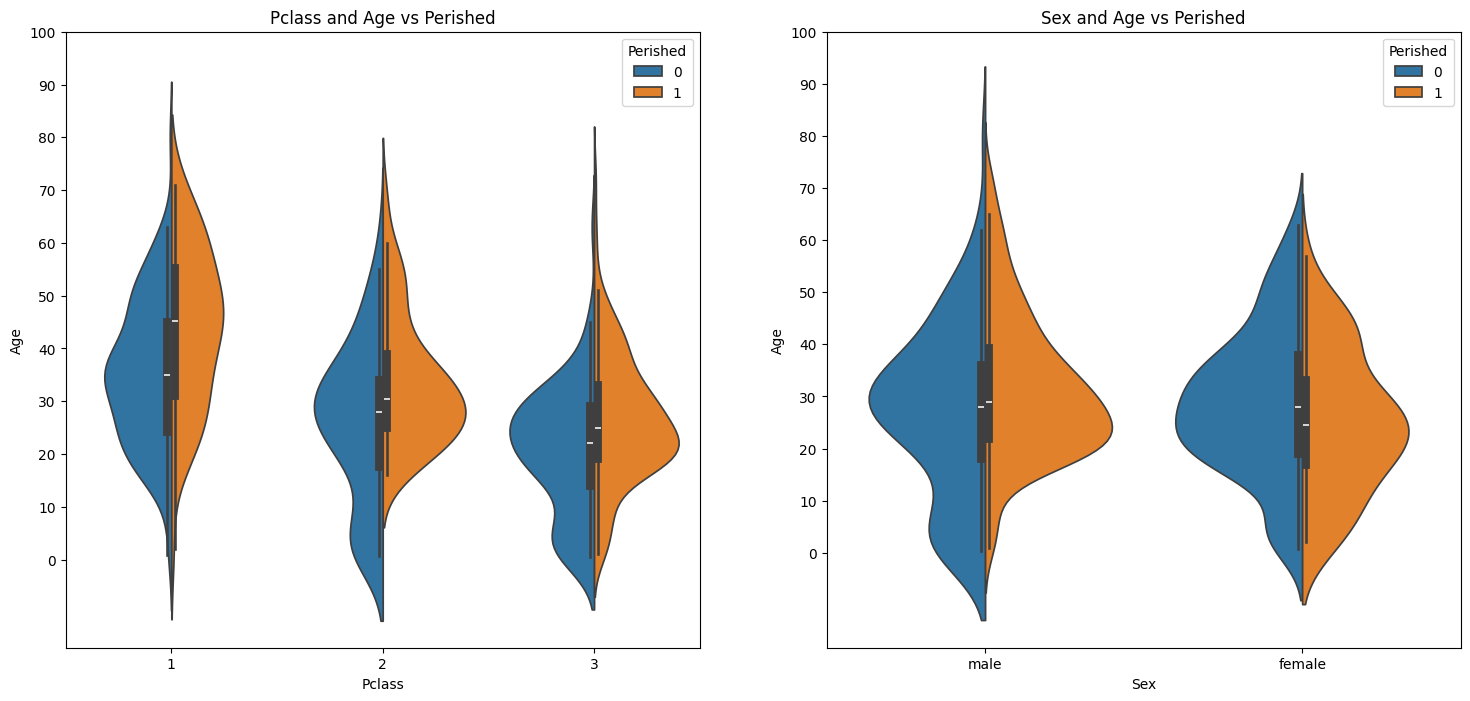

In [35]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot(x="Pclass",y="Age", hue="Perished", data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Perished')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Perished", data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Perished')
ax[1].set_yticks(range(0,110,10))
plt.show()

　このような図を**バイオリン図**と言います。身近なところでは人口推計の男女別年齢分布が似たような図で示されています。この図からどのような知見が得られるでしょうか。最も顕著な傾向の一つは男性の幼年層に見られます。10歳以下の男性は死亡率が著しく低くなっています。この事実はタイタニック号の事故において幼い男の子が優先的に助けられたことを示唆しています。他にはどのような知見が得られるか考えてみましょう。


　最後に**相関行列**の**ヒートマップ**を表示してみましょう。相関行列とは各成分に対応する相関係数を並べた行列のことであり、値の大小に応じて色をつけたものをヒートマップと呼びます。この図を表示することによって、変数間の相関の強さを一目で把握することができます。

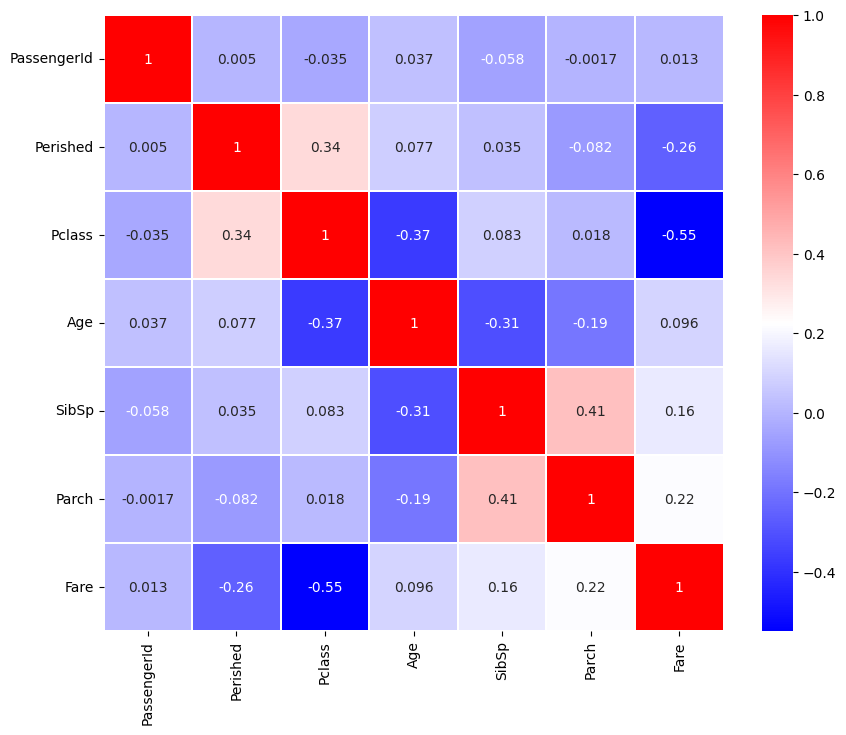

In [ ]:
# 数字列のみを抽出
df_numeric = df.select_dtypes(include=['number'])

# 相関係数を算出、相関係数表示、青から赤で表示
sns.heatmap(df_numeric.corr(),annot=True,cmap='bwr',linewidths=0.2)

# 画像所得、サイズ変更
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

　この図から、SibSpとParchの値に比較的強い正の相関があることがわかります。SibSpは同乗していた兄弟姉妹・配偶者の数であり、Parchは同乗していた親・子供の数であったので、この事実は理解しやすいでしょう。ここでSibSpの値とParchの値の和をとって「同乗していた家族の人数」という新しい変数を加えるアイデアが得られます。なぜならSibSpとParchという不自然な分類で二つの変数に分割してあるよりも「同乗していた家族の人数」という変数の方が自然である可能性があるからです。

　他にもPclassとFareの値に比較的強い負の相関が見られます。この事実は、先に見たようにPclassの値が小さいほどチケットのグレードが高いという見立てを補強しています。この見立ては正しいと見ていいでしょう。  

　このように相関が強い変数がある場合には注意が必要です。相関の強い変数を機械学習モデルの学習に用いると、一部のモデルでは**多重共線性**という問題が生じます。そのため著しく相関の強い変数がある場合は、その変数のうち一つだけを残して他の変数を削除するといった対策をすることがあります。ここでは相関が強すぎるという程では無いと見て、こうした対策は行いませんが、自分で試してみても良いでしょう。

## 1.3 データの前処理
　ここでは、機械学習モデルが学習できるようにデータの前処理を行なっていきます。


　まずは**欠損値**の補完です。先に見たように**Age**、**Fare**, **Cabin**、**Embarked**の4変数は一部が欠損していました。欠損値の補完には様々な手法があります。平均値や最頻値といった代表値で補完する手法、機械学習モデルで予測して予測値で補完する手法、-9999などの外れ値で補完することによって欠損していたという情報を保持する手法などが挙げられます。
  
　ここでは、欠損値を含む変数を削除してしまいましょう。欠損値のより良い取り扱い方については、**professional.ipynb**をご参照ください。

In [ ]:
missing_list = ['Age', 'Fare', 'Cabin', 'Embarked']

# 一度消してもう一度実行するとKeyError
print(df.columns)       # dfの列名を表示
print(df_test.columns)  # df_testの列名を表示

# 欠損値を含む列を削除
# axis=1 は列を指定して削除することを示しています。axis=0 を指定すると、行が削除されます。
# inplace=True は、元のデータフレームを変更することを示しています。この引数を指定しない場合、変更は反映されません。
df.drop(missing_list, axis=1, inplace=True)
df_test.drop(missing_list, axis=1, inplace=True)

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket'], dtype='object')


KeyError: "['Age', 'Fare', 'Cabin', 'Embarked'] not found in axis"

　次に**カテゴリカルデータ**を機械学習モデルで扱えるよう処理します。カテゴリカルデータには、**Name**, **Sex**, **Ticket**, **Embarked**がありました。  
　ここでも、カテゴリカルデータである変数を削除してしまいましょう。カテゴリカルデータのより良い取り扱い方については、**professional.ipynb**をご参照ください。

In [44]:
category_list = ['Name', 'Sex', 'Ticket']

df.drop(category_list, axis=1, inplace=True)
df_test.drop(category_list, axis=1, inplace=True)

KeyError: "['Name', 'Sex', 'Ticket'] not found in axis"

## 2. 機械学習モデルの構築・学習

　データが整形できたので、このデータを元に機械学習モデルを構築します。ここではロジスティック回帰というモデルを構築します。より本格的なモデル構築については、**professional.ipynb**をご参照ください。
  
　まずdfとdf_testを**説明変数**と**目的変数**に分けます。
- 説明変数：モデルの学習に使用する変数、今回の問題ではPassengerId, Perished以外の変数
- 目的変数：予測対象の変数, 今回の問題ではPerished  

　ここでスライスしたdfとdf_testを.valuesとしてnumpy.ndarray型に変換しているのは、機械学習モデルの実装によってはこの型のデータしか受け付けないからです。

In [52]:
print(df.columns)       # dfの列名を表示
print(df_test.columns)  # df_testの列名を表示

# 抽出したデータを表示、2列目以降を表示
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values

Index(['PassengerId', 'Perished', 'Pclass', 'SibSp', 'Parch'], dtype='object')
Index(['PassengerId', 'Pclass', 'SibSp', 'Parch'], dtype='object')


　機械学習モデルにとって最大の障害の一つは**過学習**です。過学習とは機械学習モデルが訓練データを学習する際に、訓練データに対して正しい予測を与えようとするあまり、訓練データにしか良い予測を与えられず、テストデータや他のデータに対して役に立たなくなってしまう現象のことです。

　この現象を回避するための手法の一つに**ホールドアウト法**があります。ホールドアウト法では、与えられた訓練データをさらに擬似訓練データと擬似テストデータに分割し、機械学習モデルを擬似訓練データで学習させます。その上で、擬似訓練データに対する予測精度と擬似テストデータに対する予測精度を比較して、二つの値に大きな解離が見られる場合には過学習が発生していると判断し、過学習を抑えるよう修正を加えます。  

　今回は7:3で元の訓練データを分割して、擬似訓練データ(X_train, y_train)と擬似テストデータ(X_valid, y_valid)とします。変数名は何でも構いませんが、ここで用いたvalidとはvalidation(検証)の略です。これは擬似テストデータをモデルの予測精度の検証に用いることに由来します。

　データの分割には、scikit-learnのtrain_test_split関数を使用しますが、分割はランダムに行われるため、再現性を保つためには乱数生成のシード値を引数random_stateで指定する必要があります。この値を42とする例が海外を中心に散見されるのは、この数字が、有名なSF作品「銀河ヒッチハイク・ガイド」で「生命、宇宙、そして万物についての究極の疑問の答え」とされているからだそうです。

　ホールドアウト法の拡張には、**クロスバリデーション**があります。クロスバリデーションについては、**professional.ipynb**で解説しています。

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

　ロジスティック回帰モデルを作成して、擬似訓練データ(X_train, y_train)を学習させます。

In [ ]:
lr = LogisticRegression(random_state=42)
# 特徴量Xと目的変数yを使って学習
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

　このモデルによる予測精度の評価を、今回のコンペティションで指定された評価基準である**正解率(accuracy)**で行います。先述したように、擬似訓練データ(X_train, y_train)に対するスコアと擬似テストデータ(X_valid, y_valid)に対するスコアを見ます。これらの値が著しく解離している場合には、**過学習**が発生しているとして修正を行います。

In [55]:
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

Train Score: 0.679
 Test Score: 0.705


## 3. 予測の出力・提出
　学習させたロジスティック回帰モデルを用いて、テストデータに対する予測を行います。

In [56]:
y_pred = lr.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,

　このようにして提出すべき予測値が得られました。

　最後に得られた予測値を規定の形式に整形して、csvファイルとして出力しましょう。  
　まず規定の形式を確認しましょう。README.ipynbでは以下のようなcsvファイルで提出するよう指示されていました。

PassengerID|Perished
---|---
892|0
893|1
894|0
…|…
1307|0
1308|0
1309|0

　また、gender_submission.csvがその例とされていたので、これを確認します。\
※ファイルの読み込み方法は自身の作業場所によって変わります。このnotebookをコピーして用いる場合はそのまま実行することができますが、自分の環境に合わせて適切な形に修正する必要が生じる場合もあります。

In [57]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
path = "../data/"

submission = pd.read_csv(path + 'gender_submission.csv')
submission

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [58]:
submission.head(10)

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
5,897,1
6,898,0
7,899,1
8,900,0
9,901,1


　提出ファイルを作成するには、このデータフレームのPerishedを上書きするのが手っ取り早いでしょう。

In [59]:
submission['Perished'] = y_pred
submission.head(10)

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
5,897,1
6,898,1
7,899,1
8,900,1
9,901,1


　これをcsvファイルとして出力すれば、提出ファイルの完成です。\
※csvファイル書き出しの方法は自身の作業場所によって変わります。自分の環境に合わせたコード片方を選択してください。両方または自分の環境外のコードを選択するとエラーが起こります。このnotebookをコピーして用いる場合は下のセルをそのまま実行してください。

In [61]:
# JupyterLabなどローカルで作業する場合
# パスは必要に応じて変更の必要あり
submission.to_csv('../out/submission.csv', index=False)

In [ ]:
# Google Drive・Google Colaboratoryで作業する場合

from google.colab import files
# colaboratory上に保存
# 保存したcsvファイルはランタイムが終了すると削除されます
submission.to_csv('submission.csv', index=False)
# colaboratory上に保存したcsvファイルをローカルに保存
files.download('submission.csv')

　この提出ファイルをOmnicampus上で提出してみましょう。本デモンストレーションはこれにて以上です。入門者の方もこのデモンストレーションをベースとするなどし、自分の工夫を一つでも多く加えてみて、スコアと順位の向上を目指してみてください。